In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from os import path, listdir
import numpy as np

In [2]:
dfs = []
dirs = sorted(listdir('.'))
print(dirs)
dfs = [pd.read_csv(file, comment='#') for file in dirs if file[-3:] == 'csv']

['TUMOR_2024_04_24_13_20_43.csv', 'TUMOR_2024_04_24_14_32_51.csv', 'TUMOR_2024_04_24_14_47_40.csv', 'process_andenes.ipynb']


In [3]:
df = pd.concat(dfs)

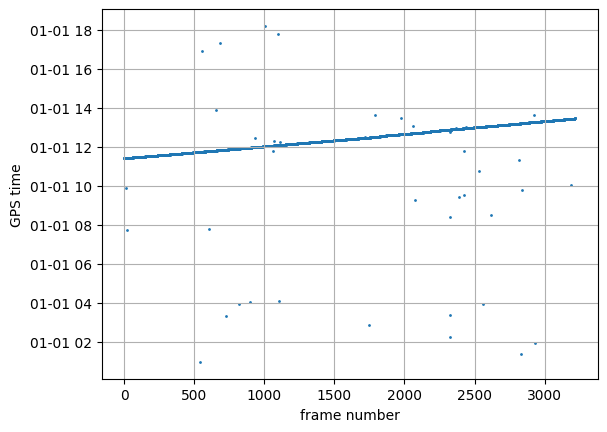

In [4]:
time = pd.to_datetime(df[f'time_GPS'], format='%H:%M:%S')
plt.scatter(np.arange(time.shape[0]), time, s=1)
plt.ylabel('GPS time')
plt.xlabel('frame number')
plt.grid()


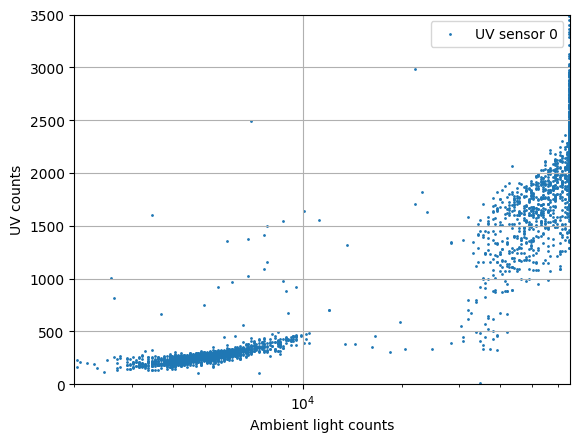

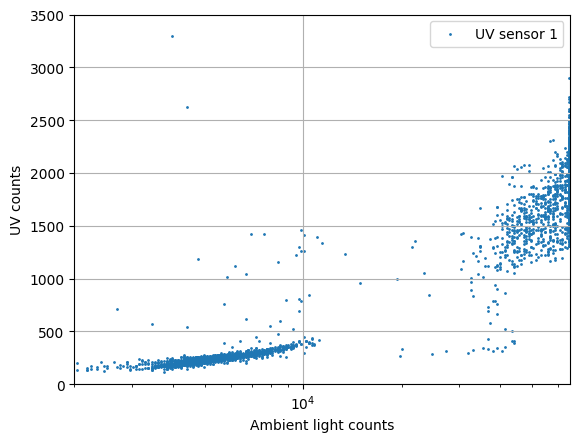

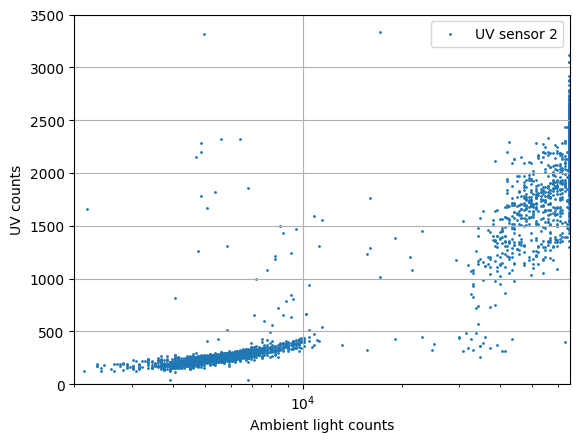

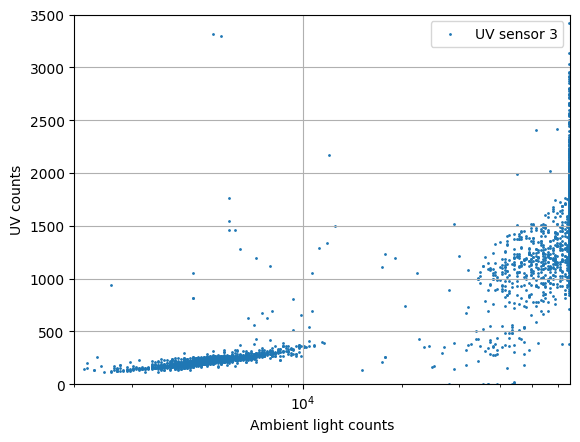

In [5]:
for i in range(4):
    plt.scatter(df[f'AL_{i}'], df[f'UV_{i}'], s=1, label=f'UV sensor {i}')
    plt.ylim((0, 3500))
    plt.xlim((2000, 65535))
    plt.xlabel('Ambient light counts')
    plt.ylabel('UV counts')
    plt.xscale('log')
    plt.legend()
    plt.grid()
    plt.show()

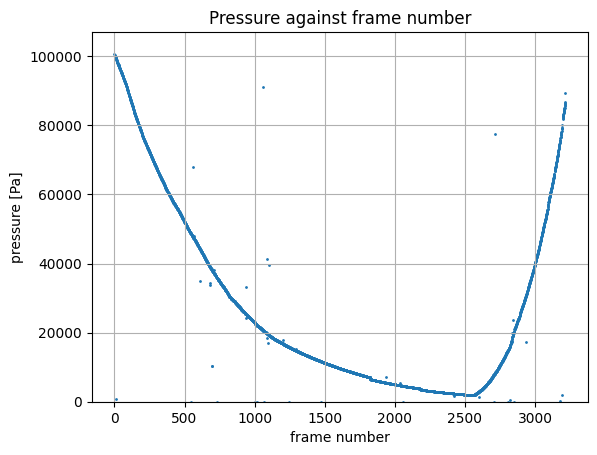

In [6]:
p = df['pressure'].to_numpy()
p = np.exp(p / 5500) - 1
plt.scatter(np.arange(p.shape[0]), p, s=1)
plt.ylim((0, 107000))
plt.ylabel('pressure [Pa]')
plt.xlabel('frame number')
plt.title('Pressure against frame number')
plt.grid()

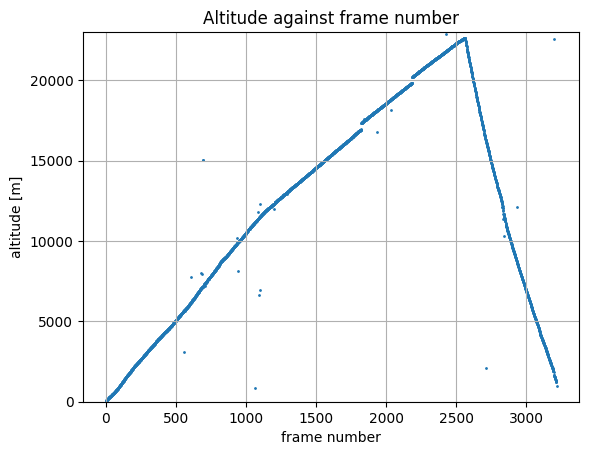

In [7]:
T0 = 277.3
p0 = 101000
alpha = -0.0065
R = 287.06
g0 = 9.81

h = T0 / alpha * ((p / p0) ** (-alpha * R / g0) - 1)
plt.scatter(np.arange(h.shape[0]), h, s=1)
plt.ylim((0, 23000))
plt.xlabel('frame number')
plt.ylabel('altitude [m]')
plt.title('Altitude against frame number')
plt.grid()

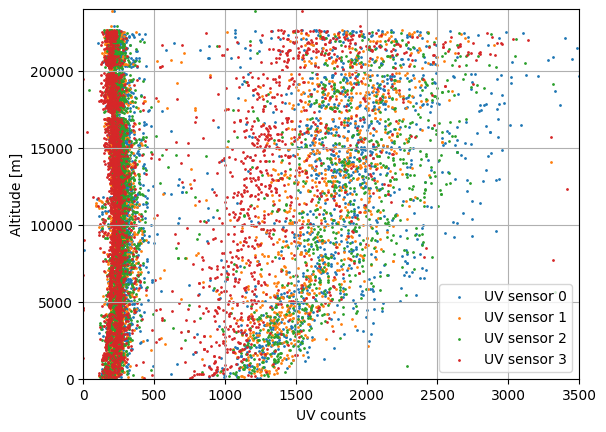

In [8]:
for i in range(4):
    plt.scatter(df[f'UV_{i}'], h, s=1, label=f'UV sensor {i}')
plt.xlim((0, 3500))
plt.ylim((0, 24000))
plt.ylabel('Altitude [m]')
plt.xlabel('UV counts')
plt.legend()
plt.grid()

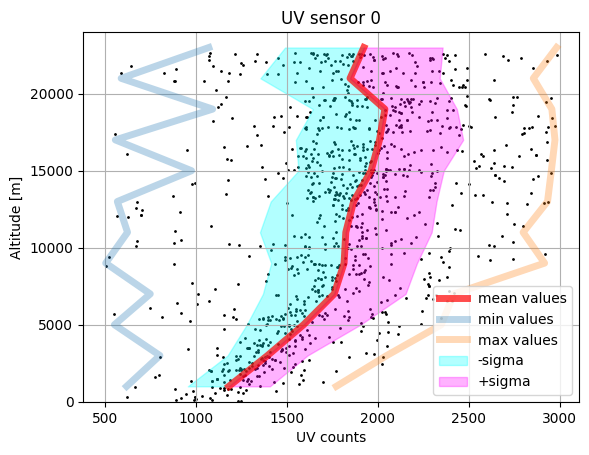

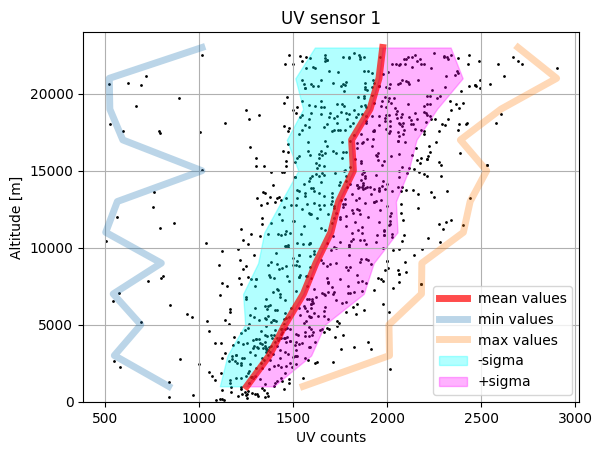

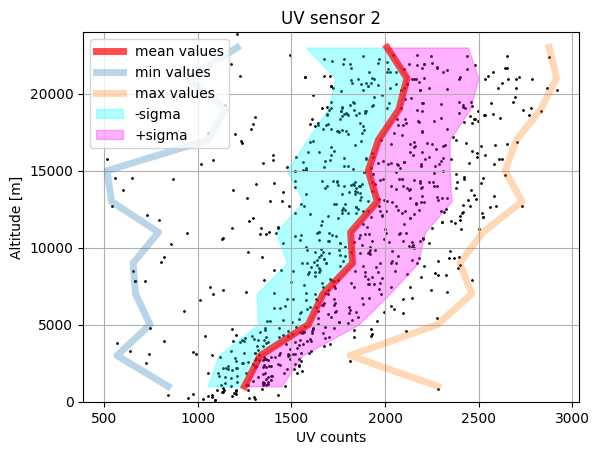

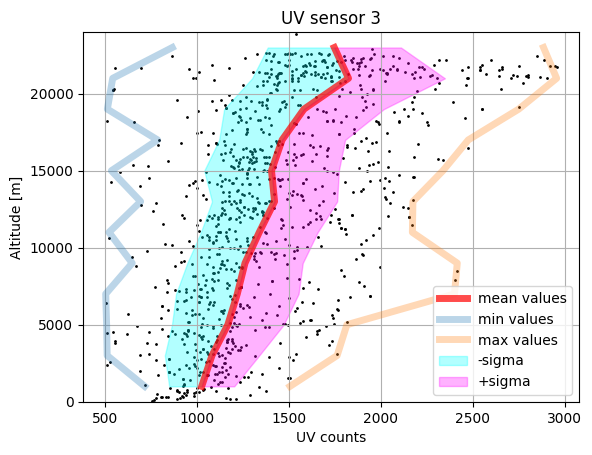

In [35]:
for i in range(4):
    uvs = df[f'UV_{i}'].to_numpy()
    mask = (uvs>500)&(uvs<3000)
    uvs = uvs[mask]
    ys = h[mask]
    plt.scatter(uvs, ys, s=1, c='k')
    plt.ylim((0, 24000))
    resolution = 2_000
    n_buckets = 12
    bucket_altitudes = [(i + 0.5) * resolution for i in range(n_buckets)]
    buckets = [uvs[(ys>resolution * i)&(ys<resolution * (i + 1))] for i in range(n_buckets)]
    means = np.array([bucket.mean() for bucket in buckets])
    mins = np.array([bucket.min() for bucket in buckets])
    maxs = np.array([bucket.max() for bucket in buckets])
    sigmas = np.array([bucket.std() for bucket in buckets])
    plt.plot(means, bucket_altitudes, label='mean values', linewidth=5, alpha=0.7, color='red')
    plt.plot(mins, bucket_altitudes, label='min values', linewidth=5, alpha=0.3)
    plt.plot(maxs, bucket_altitudes, label='max values', linewidth=5, alpha=0.3)
    plt.fill_betweenx(bucket_altitudes, means, means - sigmas, label='-sigma', alpha=0.3, color='cyan')
    plt.fill_betweenx(bucket_altitudes, means + sigmas, means, label='+sigma', alpha=0.3, color='magenta')
    plt.legend()
    plt.title(f'UV sensor {i}')
    plt.ylabel('Altitude [m]')
    plt.xlabel('UV counts')
    plt.grid()
    plt.show()

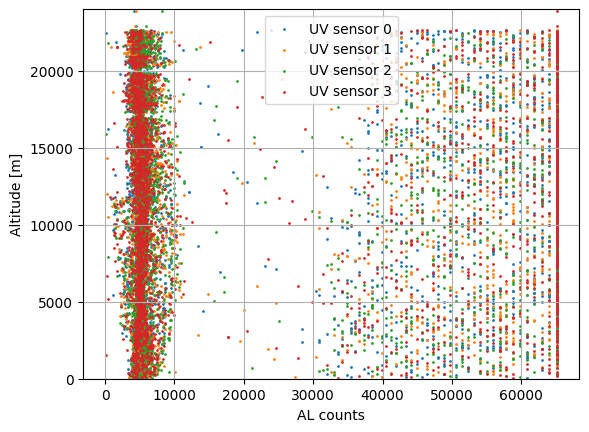

In [9]:
for i in range(4):
    plt.scatter(df[f'AL_{i}'], h, s=1, label=f'UV sensor {i}')
# plt.xlim((0, 3500))
plt.ylim((0, 24000))
plt.ylabel('Altitude [m]')
plt.xlabel('AL counts')
plt.legend()
plt.grid()

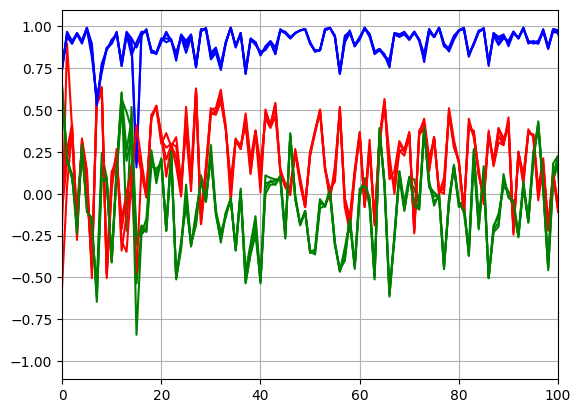

In [10]:
xs = np.arange(df.shape[0])
colours = {'x': 'r', 'y': 'g', 'z': 'b'}
for i in range(4):
    for d in ['x', 'y', 'z']:
        plt.plot(xs, df[f'M{d}_{i}'].to_numpy(), label=f'M{d}', color=colours[d])

plt.xlim((0, 100))
plt.grid()

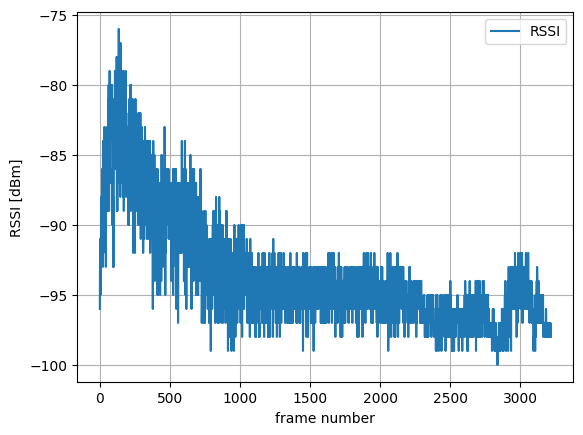

In [11]:
xs = np.arange(df.shape[0])
plt.plot(xs, df['RSSI'], label='RSSI')
plt.ylabel('RSSI [dBm]')
plt.xlabel('frame number')
plt.legend()
plt.grid()